<a href="https://www.kaggle.com/code/aylinkarl/a-b-testing-analysis?scriptVersionId=94733600" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## A/B Test data set

This dataset contains 294.478 entries showing the result of A/B testing for a user session.

We can think that this experiment is designed to decide on a change to be made on the product page of an e-commerce site. Our goal with this change will be to increase the number of customers' purchases and achieve a higher conversion rate. 

Let's say the current conversion rate averages around 13% over the year and we expect a 2% increase. It means that the new design will be considered successful if it increases the conversion rate to 15%.


**Columns:**

user_id     : The user id of each session<br>
timestamp   : The timestamp for the session<br>
group       : Defines whether the user group is assigned as Control or Treatment<br>
landing_page: Defines whether the user sees the current page (old_page) or the page to be tested (new_page)<br>
converted   : Indicates whether the session ended with a conversion (binary, 0=not converted, 1=converted)<br>


### How to conduct the A/B test?

1) First we need to design our experiment. And to do that, we should formulate a hypothesis.

In a two-tailed test, the generic null and alternative hypotheses are the following:

Null (H0): The effect equals zero.<br>
Alternative (HA): The effect does not equal zero.<br>

The significance level is the probability of rejecting the null hypothesis H0 when the null hypothesis H0 is in fact true. The higher the significance level, the more likely we can make a type I error.

The most typical value of the significance (our alpha) level is 0.05. We will also use 0.05 in this example.

So with the confidence level of 95%, our alpha value (𝛼), calculated as (1 — confidence level), will be 0.05.

Before decide to reject the Null hypothesis, we want to be 95% sure that it is statistically different from the conversion rate of our old design. If the p_value is less than the 0.05 alpha value we can reject the null hypothesis. 


2) Then we need to choose the variables. 

The Control and Treatment groups will be our independent variables, while the conversion rate will be the dependent variable. 

**Groups:**<br>
The control group - They'll be shown the old design<br>
The treatment group - They'll be shown the new design<br>

**Conversion Rate:**<br>
0 - The user did not buy the product during this user session<br>
1 - The user bought the product during this user session<br>

3) And finally, it is important to decide on the right amount of sample size.

To find the minimum required sample size to get statistically significant results we should apply mathematical statistics and power analysis.

The power analysis allows us to determine the sample size with a specific confidence level which is required to identify the effect size. 

To estimate our sample size, we must define the power and effect size of the test in addition to the significance level.

Statistical power is the probability that one or another statistical criterion can correctly reject the null hypothesis H0, in the case when the alternative hypothesis H1 is true. The higher the power of the statistical test, the less likely we can make a type II error.

In practice, usually, a test power equal to or greater than 80% is considered acceptable (which corresponds to a β-risk of 20%). This level is a consequence of the so-called "one-to-four trade-off" relationship between the levels of α-risk and β-risk: if we accept the significance level α = 0.05, then β = 0.05 × 4 = 0.20 and the power of the criterion is P = 1-0.20 = 0.80.

And we can calculate the effect size according to how big of a difference we expect there to be between conversion rates.

For this example with the difference of 2%, we can use 13% and 15% to calculate the effect size we expect.

Power of the test (1−β) : 80%<br>
Significance level (Alpha value α) : 5%<br>
Effect size : 4720 (To be calculated below)<br>


## Importing Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
from math import ceil

%matplotlib inline

In [3]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

## Calculating the Effect Size

In [4]:
# We will minimum 4720 observations for each group

effect_size = sms.proportion_effectsize(0.13, 0.15)

required_s = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)                                                  

required_s = ceil(required_s)                       

required_s

4720

## Loading and Reviewing the dataset

In [5]:
raw_data = pd.read_csv('../input/ab-testing/ab_data.csv')

In [6]:
raw_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
raw_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,294478.0,NaN,NaN,NaN,787974.124733,91210.823776,630000.0,709032.25,787933.5,866911.75,945999.0
timestamp,294478,294478,2017-01-21 22:11:48.556739,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
group,294478,2,treatment,147276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
landing_page,294478,2,old_page,147239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
converted,294478.0,NaN,NaN,NaN,0.119659,0.324563,0.0,0.0,0.0,0.0,1.0


## Data Preprocessing

In [9]:
# First, let's check if any user has been sampled multiple times.

session_counts = raw_data['user_id'].value_counts(ascending=False)
dupl_users = session_counts[session_counts > 1].count()

dupl_users

3894

In [10]:
# We can delete the users appear more than once
# While using isin function, to check if values is not in the DataFrame, use the ~ operator:

drop_list = session_counts[session_counts > 1].index

data_multi = raw_data[~raw_data['user_id'].isin(drop_list)]


print(raw_data.shape[0], data_multi.shape[0])

294478 286690


## Sampling for the test

In [11]:
control_group = data_multi[data_multi['group']=='control'].sample(n= required_s, random_state=22)

In [12]:
pd.crosstab(control_group['group'], control_group['landing_page'])

landing_page,old_page
group,
control,4720


In [13]:
treatment_group = data_multi[data_multi['group']=='treatment'].sample(n= required_s, random_state=22)

In [14]:
pd.crosstab(treatment_group['group'], treatment_group['landing_page'])

landing_page,new_page
group,
treatment,4720


In [15]:
ab_test = pd.concat([control_group,treatment_group], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0


In [16]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


## Visualising

In [17]:
conversion_rates = ab_test.groupby('group')['converted']

# Std. deviation of the proportion
std_p = lambda x: np.std(x, ddof=0)  

# Std. error of the proportion (std / sqrt(n))
se_p = lambda x: stats.sem(x, ddof=0)            

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


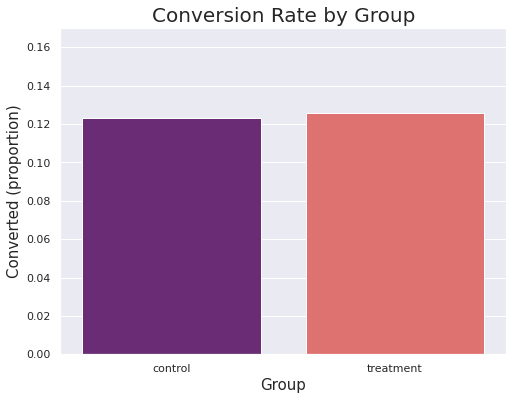

In [18]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False, palette='magma')

plt.ylim(0, 0.17)
plt.title('Conversion Rate by Group', size=20)
plt.xlabel('Group', size=15)
plt.ylabel('Converted (proportion)', size=15);

The conversion rates are quite similar which are 12.3% for control group while for treatment group 12.6%. 

The treatment group's value is higher but we need to check if this difference statistically significant. :)

## Testing the Hypothesis

In [19]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [20]:
nr_control = control_results.count()
nr_treatment = control_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nr_obs = [nr_control, nr_treatment]

In [21]:
z_stat, pvalue = proportions_ztest(successes, nobs=nr_obs)

# Confidence interval
(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(successes, nobs=nr_obs, alpha=0.05)

In [22]:
print('Z Statistic              : {:.2f}'.format(z_stat))
print('P-Value                  : {:6.3f}'.format(pvalue))
print('CI 95% for control group : [{:.3f},{:.3f}]'.format(lower_control, upper_control))
print('CI 95% for control group : [{:.3f},{:.3f}]'.format(lower_treatment, upper_treatment))

Z Statistic              : -0.34
P-Value                  :  0.732
CI 95% for control group : [0.114,0.133]
CI 95% for control group : [0.116,0.135]


Based on the p-value of 0.0732 which is much higher then our alfa(0.05), we can not reject the null hypothesis.

Our new page design have same similar effect with the old one 😌 

Also confidence interval for the treatment group shows that we can not reach the desired conversion rate of 15%. Let's hope to reach with the next design work ☀️

I hope that you find it useful. As I will be happy to improve myself, your comments and feedbacks are always welcome, as are suggestions for additional information that could usefully be included. Thank you! 🌸😊